## Importar librerías

In [689]:
import pandas as pd
from nltk.corpus import stopwords
import seaborn as sns
import numpy as np
import spacy 
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import networkx as nx
import cufflinks as cf
import plotly.express as px
from ipywidgets import interact
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, IntSlider
import ipywidgets as widgets
import plotly.graph_objects as go

## Data Cleanning

In [690]:
friends = pd.read_csv("friends_quotes.csv")

In [691]:
friends.drop(friends[(friends["season"] == 1) & (friends["episode_number"] == 16)].index,inplace = True) #el episodio 16 no está bien escrapeado

In [692]:
chandler =["CHAN","CHANDLER","Chandler (Stands up and walks to Joey)","Chandle","Chandler (nearly weeping)","Chandler (to Joey)", "Chandler (to Monica)", "Chandlers"]
monica =["Young Monica","Fake Monica", "Fat Monica", "MONICA","MNCA","MOnica","Monic","Monica (to Ross)","Monica about to have a heart attack","Monica to Amy","Monica to Emma","Monica to Ross","Monica (reads a form in her lap)"] 
joey = ["Fat Joey","JOEY","Joe","Joey (staring at the cake)","Joey (to Rachel)","Joey (to Ross)"]
phoebe = ["PHOE","PHOEBE","Phoeb","Phoebe (to Mike)","Phoebe (to Rachel)","Phoebe (walking to Ross carrying a black leather jacket)","Phoebe (watching the food on the table)","Phoebe looks down"]
rachel = ["Big nosed rachel","RACH","RACHEL","RAHCEL", "Rache","Rachel (crying)","Rachel (leaving)","Rachel (on the phone)","Rachel (she flips the coin)","Rachel opens their door","Rachel to Emma","Rachel (as Monica)","Racel"]
ross = ["ROSS","Ross (on the verge of tears)","Ross (stops recording)","Ross (to Emma)","Ross first has a look of 'huh' then changes it to sarcastic happy","Ross looks down","Ross makes some sort of sound to let us know it hurt","Ross starts playing with a plate","Ross starts talking over her 'do you remember' line","Ross to Monica","Ross with a look of wondering how long this is going to go on on his face","Young Ross","ros"]

In [693]:
friends["author"] = friends["author"].apply(lambda x: "Chandler" if x in chandler else x).apply(lambda x: "Phoebe" if x in phoebe else x).apply(lambda x: "Joey" if x in joey else x).apply(lambda x: "Rachel" if x in rachel else x).apply(lambda x: "Ross" if x in ross else x).apply(lambda x: "Monica" if x in monica else x).str.strip().str.lower().str.replace("ms. geller","mrs. geller").str.replace("judy","mrs. geller").str.replace("frank jr","frank").str.capitalize()

In [694]:
friends.drop(friends[(friends["author"] == "All")].index,inplace = True)

In [695]:
friends[friends.season == 7]["author"].value_counts().head(9)

Rachel        1098
Joey           951
Monica         912
Chandler       855
Ross           838
Phoebe         811
Tag            131
Mr. geller      60
Ben             57
Name: author, dtype: int64

## Characters with more Lines/Season

In [696]:
@interact(Season = IntSlider(min=1, max=10, step=1,value=1))
def more_common_characters(Season):
    more_common_characters = friends[friends.season == Season]["author"].value_counts().head(9).index.to_list()
    sns.set(rc={'figure.figsize':(7,7), 'axes.facecolor':'black'}, font_scale=1.5)
    palette = ["#ed1111","#f4f723","#23c6f7"]
    sns.countplot(y='author', data=friends[(friends.author.isin(more_common_characters)) & (friends.season == Season)], order = more_common_characters, palette = palette)
    plt.xlabel("Number of lines")
    plt.ylabel("Character")

interactive(children=(IntSlider(value=1, description='Season', max=10, min=1), Output()), _dom_classes=('widge…

## Season 1: Conversations between the most common characters

### Code

In [697]:
more_common_characters_season_1 = friends[friends.season == 1.0]["author"].value_counts().head(9).index.to_list()
print(more_common_characters_season_1)

['Ross', 'Monica', 'Rachel', 'Chandler', 'Joey', 'Phoebe', 'Carol', 'Susan', 'Janice']


In [698]:
season1_df = friends[(friends.season == 1.0) & friends["author"].isin(more_common_characters_season_1)]

In [699]:
season1_df.to_excel(r"./season1_df.xlsx", index = False)

In [700]:
season_1_main_characters = pd.read_excel("season1_df_modified.xlsx")

In [701]:
conversation_weights = season_1_main_characters["Conversation"].value_counts(normalize = True)
conversation_weights

Ross, Rachel        0.171171
Ross, Carol         0.114114
Chandler, Joey      0.113113
Rachel, Monica      0.086086
Chandler, Phoebe    0.083083
Ross, Joey          0.079079
Susan, Ross         0.065065
Monica, Joey        0.062062
Chandler, Janice    0.054054
Phoebe, Rachel      0.038038
Phoebe, Monica      0.033033
Ross, Chandler      0.031031
Joey, Phoebe        0.022022
Susan, Carol        0.020020
Chandler, Monica    0.016016
Chandler, Rachel    0.009009
Ross, Phoebe        0.002002
Janice, Joey        0.001001
Name: Conversation, dtype: float64

In [702]:
conversation_weights = pd.DataFrame(conversation_weights).reset_index()

In [703]:
conversation_weights[["A","B"]] = conversation_weights["index"].str.split(",",expand=True)

In [704]:
conversation_weights["A"] = conversation_weights["A"].str.strip()
conversation_weights["B"] = conversation_weights["B"].str.strip()

### Plot

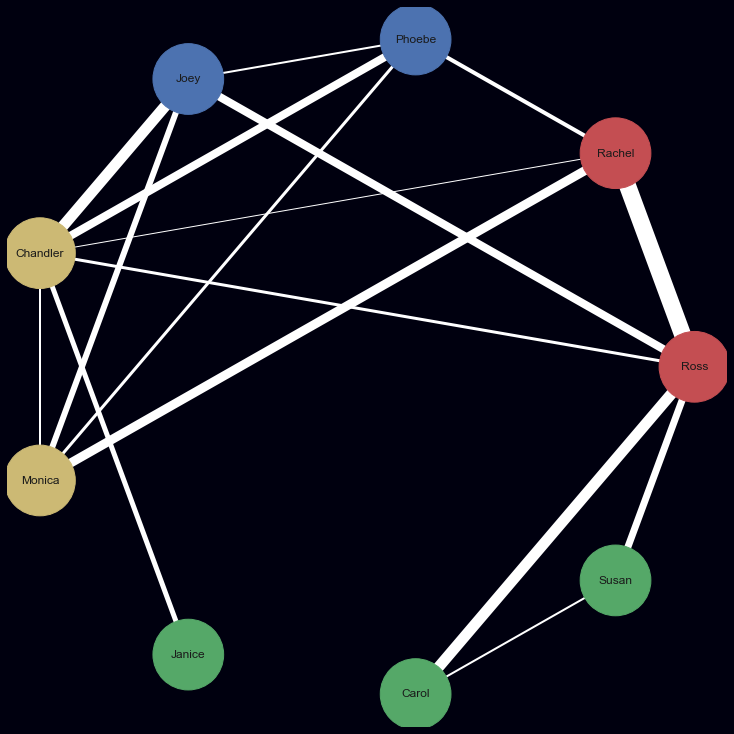

In [705]:
plt.rcParams["figure.figsize"] = (10,10)

G = nx.Graph()
G.add_node("Ross", color='r')
G.add_node("Rachel", color='r')
G.add_node("Phoebe", color='b')
G.add_node("Joey", color='b')
G.add_node("Chandler", color='y')
G.add_node("Monica", color='y')
G.add_node("Janice", color='g')
G.add_node("Carol", color='g')
G.add_node("Susan", color='g')

for i in range(len(conversation_weights)):
    G.add_edge(conversation_weights["A"][i],conversation_weights["B"][i], weight=round(conversation_weights["Conversation"][i]*100))

colors_nodes = nx.get_node_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()
pos = nx.circular_layout(G)

fig = plt.figure()
nx.draw(G, pos, 
        edge_color="white", 
        width=list(weights),
        with_labels=True,
        node_color= colors_nodes, node_size=5000)
fig.set_facecolor("#00000F")

## Guests Stars over the 10 seasons

In [706]:
guest_stars = pd.read_excel("Guest_Stars_DF.xlsx")

In [707]:
guest_stars = pd.pivot_table(guest_stars,index=["Actor","season"],
                values = ["quote"],           
               aggfunc='count',fill_value=0)

In [708]:
guest_stars.reset_index(inplace = True)

In [709]:
fig = px.bar(guest_stars, x="season", y="quote", color = "Actor", title="Guest Stars over the 10 Seasons", labels = {"quote": "Number of lines", "season": "Seasons 1 to 10"})
fig.show()

## Sentiment Analysis

### Cleanning

In [710]:
main_characters = ["Ross", "Joey","Chandler","Phoebe","Rachel","Monica"]

In [711]:
friends= friends[friends.author.isin(main_characters)].drop(columns=['episode_number', 'episode_title', "quote_order"]).reset_index(drop = True)

In [712]:
friends["quote"] = friends["quote"].str.replace("\(([^)]+)\)","").str.strip().str.lower().str.split("[.|!|?]", expand = False)

In [713]:
friends = friends.explode("quote")

In [714]:
friends.reset_index(drop = True, inplace = True)

In [715]:
scene = friends[friends["quote"].str.contains("scene:")].index.to_list()

In [716]:
friends = friends.drop(friends.index[scene])

In [717]:
friends["quote"] = friends["quote"].str.replace("[^a-zA-Z' ]","")

In [718]:
friends.reset_index(drop = True, inplace = True)

In [719]:
indexes = []
for i in range(len(friends["quote"])):
    if len(friends["quote"][i]) == 0:
        indexes.append(i)

In [720]:
friends = friends.drop(friends.index[indexes]).reset_index(drop = True)

In [721]:
friends["quote"] = friends["quote"].str.strip()

In [722]:
friends['number_words'] = friends['quote'].str.count(' ') + 1

In [723]:
one_word = friends[friends["number_words"] == 1].index.to_list()

In [724]:
friends = friends.drop(friends.index[one_word]).reset_index(drop = True)

In [725]:
friends["quote"] = friends["quote"].str.replace("'\s","")

In [726]:
friends["quote"] = friends["quote"].str.replace("'cause","because").str.replace("you know","y'know").str.replace("you are","you're").str.replace("come on","c'mon").str.replace("'kay","okay").str.replace("'em","them").str.replace("doin'","doing").str.replace("(ya)","you").str.replace("lemme","let me").str.replace("gonna", "going to").str.replace("'", "")

In [727]:
friends.drop('number_words', axis='columns', inplace=True)

In [728]:
friends.head()

,author,quote,season
0,Monica,theres nothing to tell,1.0
1,Monica,hes just some guy i work with,1.0
2,Joey,cmon youre going out with the guy,1.0
3,Joey,theres gotta be something wrong with him,1.0
4,Chandler,all right joey be nice,1.0


### TextBlob

#### By sentence

In [729]:
from textblob import TextBlob

In [730]:
#Less than 0 denotes Negative
#Equal to 0 denotes Neutral
#Greater than 0 denotes Positive

In [731]:
def polarity(x):
    return TextBlob(x).polarity

In [732]:
def sentiment_analysis(x):
    if x > 0.5: 
        x = "Positive"
    elif x < -0.5:
        x = "Negative"
    else:
        x = "Neutral"
    return x

In [733]:
friends["polarity"] = friends["quote"].apply(polarity).apply(sentiment_analysis)

In [734]:
sentimentanalysis = pd.pivot_table(friends,index=["author"],columns = ["polarity"],
                values = ["quote"],           
               aggfunc='count',fill_value=0)

In [735]:
sentimentanalysis

quote                 
polarity Negative Neutral Positive
author                            
Chandler      246   10651      591
Joey          197   11199      558
Monica        227   10853      533
Phoebe        178   10178      534
Rachel        221   12055      598
Ross          176   11984      569

In [736]:
friends[friends.polarity == "Positive"].head(15)

,author,quote,season,polarity
33,Ross,i hope shell be very happy,1.0,Positive
68,Rachel,this really gorgeous lamauge gravy boat,1.0,Positive
112,Monica,okay look this is probably for the best yknow,1.0,Positive
134,Ross,thatd be good,1.0,Positive
149,Phoebe,that cant be good,1.0,Positive
173,Chandler,its a beautiful thing,1.0,Positive
185,Joey,she got the furniture the stereo the good tv w...,1.0,Positive
224,Joey,this is the best thing that ever happened to you,1.0,Positive
228,Ross,i honestly dont know if im hungry or horny,1.0,Positive
240,Rachel,but joanne loved chachi,1.0,Positive


#### By words

#### Code

In [737]:
vectorizer = CountVectorizer(min_df = 0.0002, ngram_range =(1,1))
matrix = vectorizer.fit_transform(friends["quote"])
matrix

<71548x1784 sparse matrix of type '<class 'numpy.int64'>'
	with 415330 stored elements in Compressed Sparse Row format>

In [738]:
matrix.shape

(71548, 1784)

In [739]:
y = friends.iloc[:, 0].values

In [740]:
counts = pd.DataFrame(matrix.toarray(),index = list(y),
                      columns=vectorizer.get_feature_names())

In [741]:
counts = counts.groupby(counts.index).sum()

In [742]:
counts.T.columns

Index(['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross'], dtype='object')

In [743]:
most_spoken_words = counts.T.reset_index()
most_spoken_words

,index,Chandler,Joey,Monica,Phoebe,Rachel,Ross
0,able,11,9,10,8,12,16
1,about,344,406,390,322,391,398
2,absolutely,4,4,9,6,15,8
3,accent,2,5,4,2,1,5
4,accept,5,0,4,2,3,7
...,...,...,...,...,...,...,...
1779,yours,19,13,14,13,12,12
1780,yourself,20,16,28,26,21,20
1781,youve,41,34,41,37,47,45
1782,youyou,12,18,18,3,16,37


In [744]:
stop_words = stopwords.words('english')

In [745]:
most_spoken_words["sentiment"] = most_spoken_words["index"].apply(polarity).apply(sentiment_analysis)

In [746]:
most_spoken_words.drop(most_spoken_words[most_spoken_words["index"].isin(stop_words)].index,inplace = True)

In [747]:
most_spoken_words.drop(most_spoken_words[most_spoken_words["sentiment"]=="Neutral"].index,inplace = True)

In [748]:
most_spoken_words.set_index(['index','sentiment'], inplace = True)

#### Plot

In [764]:
@interact(actor =list(most_spoken_words.columns))
def sentiment(actor):
    x = pd.DataFrame(most_spoken_words.loc[:,actor]).reset_index()
    positive = x[x.sentiment == "Positive"].sort_values(by = actor, ascending = False).head(10)
    negative = x[x.sentiment == "Negative"].sort_values(by = actor, ascending = False).head(10)
    negative[actor] = negative[actor] * -1
    sa_ch = pd.concat([positive,negative])
    gfg = sa_ch.pivot_table(sa_ch,index='index', columns='sentiment', fill_value = 0)
    gfg.columns = gfg.columns.droplevel(0)
    
    Diverging = go.Figure()
    Diverging.add_trace(go.Bar(x=gfg["Negative"],
                               y=gfg.index,
                               orientation='h',
                               name="Negative",
                               hovertemplate="%{y}: %{x}"))

    Diverging.add_trace(go.Bar(x=gfg["Positive"],
                               y=gfg.index,
                               orientation='h',
                               name="Positive",
                               hovertemplate="%{y}: %{x}"))

    Diverging.update_layout(title_text= f"{actor}'s Sentiment Analysis")
    Diverging.show()

interactive(children=(Dropdown(description='actor', options=('Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel',…

## TfidfVectorizer (most spoken words)

In [765]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 0.0002, ngram_range =(3,3))

In [766]:
X = tfidf.fit_transform(friends["quote"])
y = friends.iloc[:, 0].values

In [767]:
counts2 = pd.DataFrame(X.toarray(),index = list(y),
                      columns=tfidf.get_feature_names())
counts2 = counts2.groupby(counts2.index).sum()

In [768]:
counts2.T["Joey"].sort_values(ascending = False).head(15)

im going to       57.345227
oh my god         53.227403
going to be       51.587350
what are you      36.516981
check it out      31.715823
youre going to    30.861968
no no no          27.154339
what do you       26.376158
do you think      24.761189
going to do       23.226338
dont want to      23.080978
are you doing     21.512586
not going to      21.251351
want you to       18.619246
days of our       18.579231
Name: Joey, dtype: float64

## Código Extra

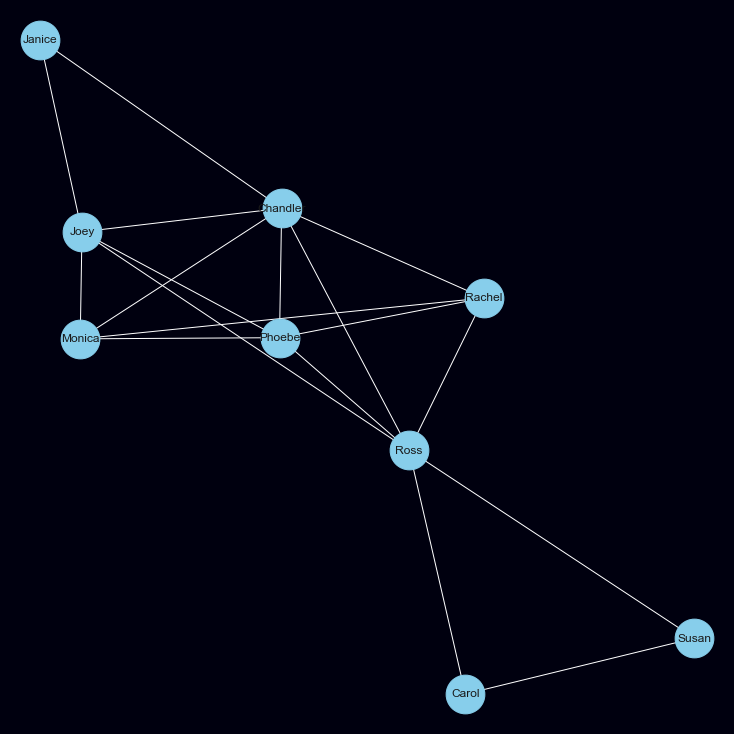

In [769]:
G=nx.from_pandas_edgelist(conversation_weights, 'A', 'B', create_using=nx.Graph() )
 
# Custom the nodes:
fig = plt.figure()
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_color='white')
fig.set_facecolor("#00000F")